In [10]:
import sys
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import seaborn as sns
from matplotlib.colors import ListedColormap

sys.path.append('./src')
import BNMPy

network_file = '../input_files/Palma2021.txt' # contains the phenotype nodes
network_file_no_phenotype = '../input_files/Palma2021_no_phenotype.txt' # no phenotype nodes

drugs = [
"Entospletinib",
"Ibrutinib",
"Trametinib",
"Venetoclax",
"Gilteritinib",
"Selumetinib",
"Midostaurin",
"Ivosidenib",
"Enasidenib"
]

In [ ]:
# Read the data
mutations = pd.read_csv("https://github.com/biodev/beataml2.0_data/raw/main/beataml_wes_wv1to4_mutations_dbgap.txt", sep='\t')
clinical = pd.read_excel("https://github.com/biodev/beataml2.0_data/raw/main/beataml_wv1to4_clinical.xlsx")
classification = pd.read_csv("../input_files/Palma_class.csv")

# Process the dataset
# Merge the df based on sample id
df = pd.merge(
    left=mutations,
    right=clinical,
    left_on='dbgap_sample_id',
    right_on='dbgap_dnaseq_sample'
)
df['survivalYears'] = df['ageAtDiagnosis'] + df['overallSurvival']/365

# Add FLT3-ITD
flt3_positive_df = df[df['FLT3-ITD'] == 'positive'].copy()
flt3_positive_df['symbol'] = 'FLT3'

clinical_df = pd.concat([df, flt3_positive_df], ignore_index=True)

# Filter the mutations that would alter protein functions
df = clinical_df[
    (clinical_df['symbol'].isin(pbn.nodeDict.keys())) &
    (
        # Apply 'sift' and 'polyphen' filters 
        ((clinical_df['sift'].str.startswith('deleterious')) &
         (clinical_df['polyphen'].str.startswith(('probably_damaging', 'possibly_damaging')))
    ))
]

patient_to_mutations = df.groupby('dbgap_subject_id')['symbol'].apply(set).reset_index()
patient_to_mutations.rename(columns={'symbol': 'profile'}, inplace=True)

# Convert blast percentage to numeric, coercing errors to NaN
profile_df = df.copy()
profile_df = profile_df.merge(patient_to_mutations, on='dbgap_subject_id', how='left')
profile_df['%.Blasts.in.BM'] = pd.to_numeric(profile_df['%.Blasts.in.BM'], errors='coerce')
profile_df['%.Blasts.in.PB'] = pd.to_numeric(profile_df['%.Blasts.in.PB'], errors='coerce')

# Aggregate for each patient
profile_df = profile_df.groupby('dbgap_subject_id').agg({
    '%.Blasts.in.BM': 'mean', 
    '%.Blasts.in.PB': 'mean',
    'profile': 'first'
}).reset_index()
profile_df

,dbgap_subject_id,%.Blasts.in.BM,%.Blasts.in.PB,profile
0,2000,10.0,1.0,{FLT3}
1,2003,NaN,50.0,{FLT3}
2,2005,50.0,NaN,{TP53}
3,2007,93.0,99.0,{DNMT3A}
4,2008,17.0,5.3,{DNMT3A}
...,...,...,...,...
310,2829,50.5,53.0,{TP53}
311,2831,NaN,NaN,{FLT3}
312,2832,26.0,NaN,{DNMT3A}
313,2834,95.0,NaN,{TP53}


In [22]:
# drug_response = pd.read_csv("https://media.githubusercontent.com/media/biodev/beataml2.0_data/main/beataml_probit_curve_fits_v4_dbgap.txt", sep='\t', usecols=['inhibitor', 'dbgap_dnaseq_sample', 'auc', 'ic50'])
drug_response['inhibitor'].unique()

array(['Axitinib (AG-013736)', 'Crenolanib', 'Crizotinib (PF-2341066)',
       'Dasatinib', 'Erlotinib', 'Gefitinib', 'Ibrutinib (PCI-32765)',
       'Imatinib', 'Lapatinib', 'Nilotinib', 'Pazopanib (GW786034)',
       'Ponatinib (AP24534)', 'Quizartinib (AC220)',
       'Ruxolitinib (INCB018424)', 'Sorafenib', 'Sunitinib',
       'Bortezomib (Velcade)', 'Rapamycin', 'Vandetanib (ZD6474)',
       'AKT Inhibitor IV', 'AKT Inhibitor X', 'AMPK Inhibitor', 'AST-487',
       'AZD1152-HQPA (AZD2811)', 'Alisertib (MLN8237)', 'CYT387',
       'Canertinib (CI-1033)', 'Doramapimod (BIRB 796)',
       'Dovitinib (CHIR-258)', 'Flavopiridol', 'GDC-0941', 'GW-2580',
       'Go6976', 'H-89', 'INK-128', 'Idelalisib', 'JAK Inhibitor I',
       'JNJ-7706621', 'JNK Inhibitor II', 'KN92', 'KN93', 'LY-333531',
       'LY294002', 'Linifanib (ABT-869)', 'MEK1/2 Inhibitor',
       'Midostaurin', 'Motesanib (AMG-706)', 'NF-kB Activation Inhibitor',
       'PD153035', 'PD98059', 'PI-103', 'PP2', 'PRT062070',
  

In [91]:
# map inhibitors to their target genes
drug_target_df = pd.read_excel("https://github.com/biodev/beataml2.0_data/raw/main/beataml_drug_families.xlsx", sheet_name='drug_gene', usecols=['inhibitor', 'Symbol'])
drug_target_df = drug_target_df[drug_target_df['inhibitor'].apply(lambda x: any(drug in x for drug in drugs))].copy()
drug_target_df

,inhibitor,Symbol
68,Venetoclax,BCL2
73,Ibrutinib (PCI-32765),CSK
80,Midostaurin,TBK1
93,Midostaurin,JAK3
101,Midostaurin,MAP3K9
102,Midostaurin,MAP3K11
142,Ibrutinib (PCI-32765),BLK
145,Ibrutinib (PCI-32765),FGR
158,Ibrutinib (PCI-32765),HCK
171,Ibrutinib (PCI-32765),PTK6


# BeatAML data

This follows the exact approach from the BeatAML2 manuscript   
(see https://github.com/biodev/beataml2_manuscript/blob/main/R/preprocess.R, function `mutation.only.dataset()`):

1. Filter clinical data: Only samples with `manuscript_dnaseq == 'yes'`
2. Create binary mutation matrix: Rows = patients (ptid), Columns = genes, Values = 1 (mutation present) or 0 (absent)
3. Add consensus annotations: Override with manual annotations from clinical file for:
   - NPM1 (from NPM1 column: positive = 1)
   - FLT3_ITD (from FLT3-ITD column: positive = 1)
   - RUNX1 (from RUNX1 column: not NA = 1)
   - ASXL1 (from ASXL1 column: not NA = 1)
   - TP53 (from TP53 column: not NA = 1)

In [11]:
# BeatAML data
drug_response = pd.read_csv("https://media.githubusercontent.com/media/biodev/beataml2.0_data/main/beataml_probit_curve_fits_v4_dbgap.txt", sep='\t')
mutations = pd.read_csv("https://github.com/biodev/beataml2.0_data/raw/main/beataml_wes_wv1to4_mutations_dbgap.txt", sep='\t')
clinical = pd.read_excel("https://github.com/biodev/beataml2.0_data/raw/main/beataml_wv1to4_clinical.xlsx")

# Filter clinical data to those with DNA sequencing
dna_clin = clinical[clinical['manuscript_dnaseq'] == 'yes'].copy()

# Merge with clinical data 
dna_clin['ptid'] = 'pt' + dna_clin['dbgap_subject_id'].astype(str)
muts_merged = pd.merge(
    dna_clin[['ptid', 'dbgap_dnaseq_sample', 'cohort', 'NPM1', 'FLT3-ITD', 'RUNX1', 'ASXL1', 'TP53']],
    mutations,
    left_on='dbgap_dnaseq_sample',
    right_on='dbgap_sample_id',
    how='inner'
)
# Create binary mutation matrix (patient x gene): if a patient has any mutation in a gene, mark as 1
muts_merged['value'] = 1
mutation_matrix = muts_merged.pivot_table(
    index='ptid',
    columns='symbol',
    values='value',
    aggfunc='max',  # If multiple mutations in same gene, still just 1
    fill_value=0
)
# Add manual annotations from clinical data (NPM1, FLT3-ITD, RUNX1, ASXL1, TP53)
manual_muts = dna_clin.set_index('ptid')[['NPM1', 'FLT3-ITD', 'RUNX1', 'ASXL1', 'TP53']].copy()
manual_muts['NPM1'] = (manual_muts['NPM1'] == 'positive').astype(int)
manual_muts['FLT3_ITD'] = (manual_muts['FLT3-ITD'] == 'positive').astype(int)
manual_muts['RUNX1'] = manual_muts['RUNX1'].notna().astype(int)
manual_muts['ASXL1'] = manual_muts['ASXL1'].notna().astype(int)
manual_muts['TP53'] = manual_muts['TP53'].notna().astype(int)
manual_muts = manual_muts[['NPM1', 'FLT3_ITD', 'RUNX1', 'ASXL1', 'TP53']]

# some patients in clinical file don't have WES mutations
missing_patients = list(set(manual_muts.index) - set(mutation_matrix.index))
if missing_patients:
    missing_df = pd.DataFrame(0, index=missing_patients, columns=mutation_matrix.columns)
    mutation_matrix = pd.concat([mutation_matrix, missing_df])

# Add missing gene columns if needed
for gene in ['FLT3', 'FLT3_ITD', 'NPM1', 'RUNX1', 'ASXL1', 'TP53']:
    if gene not in mutation_matrix.columns:
        mutation_matrix[gene] = 0

# Override with consensus annotations for NPM1, RUNX1, ASXL1, TP53
# For FLT3_ITD: update the FLT3_ITD column with clinical consensus
common_patients = list(set(manual_muts.index) & set(mutation_matrix.index))
for gene in ['NPM1', 'FLT3_ITD', 'RUNX1', 'ASXL1', 'TP53']:
    mutation_matrix.loc[common_patients, gene] = manual_muts.loc[common_patients, gene]

# Keep any patient with FLT3 from WES OR FLT3_ITD from clinical
mutation_matrix['FLT3_combined'] = ((mutation_matrix['FLT3'] == 1) | (mutation_matrix['FLT3_ITD'] == 1)).astype(int)

print(f"Mutation matrix shape: {mutation_matrix.shape}")

# mutation frequencies as percentages
mut_freq = mutation_matrix.sum().sort_values(ascending=False)
mut_pct = (mut_freq / len(mutation_matrix) * 100).round(1)
print(f"\nTop 20 most frequent mutations:")
for gene, pct in mut_pct.head(20).items():
    print(f"  {gene}: {pct}%")

# dbgap_sample_id -> ptid -> mutation profile
sample_to_ptid = dna_clin[['dbgap_dnaseq_sample', 'ptid', 'dbgap_subject_id', 'cohort']].copy()
sample_to_ptid.rename(columns={'dbgap_dnaseq_sample': 'dbgap_sample_id'}, inplace=True)

Mutation matrix shape: (713, 2989)

Top 20 most frequent mutations:
  FLT3_combined: 29.7%
  NPM1: 25.8%
  FLT3_ITD: 22.4%
  DNMT3A: 21.6%
  NRAS: 14.3%
  TET2: 13.7%
  RUNX1: 13.5%
  IDH2: 13.3%
  SRSF2: 12.2%
  ASXL1: 10.8%
  TP53: 10.7%
  FLT3: 9.0%
  STAG2: 7.9%
  IDH1: 7.6%
  WT1: 7.3%
  BCOR: 5.9%
  CEBPA: 5.8%
  U2AF1: 5.3%
  KRAS: 5.0%
  PTPN11: 4.9%


In [ ]:
# Create dataset with drug response and mutations
sample_mutations = {}
for ptid in mutation_matrix.index:
    mutated_genes = mutation_matrix.loc[ptid][mutation_matrix.loc[ptid] == 1].index.tolist()
    # Filter to only model genes
    # mutated_genes_in_model = [g for g in mutated_genes if g in pbn.nodeDict.keys()]
    mutated_genes_in_model = [g for g in mutated_genes if g in ['FLT3_ITD', 'NPM1', 'DNMT3A']]
    sample_mutations[ptid] = set(mutated_genes_in_model)

# Create mutation profile mapping
mutation_profiles = []
for _, row in sample_to_ptid.iterrows():
    ptid = row['ptid']
    if ptid in sample_mutations:
        mutation_profiles.append({
            'dbgap_sample_id': row['dbgap_sample_id'],
            'ptid': ptid,
            'mutation_profile': sample_mutations[ptid]
        })

mutation_profile_df = pd.DataFrame(mutation_profiles)

# Merge with drug response data
drug_response_merged = pd.merge(
    mutation_profile_df,
    drug_response,
    left_on='dbgap_sample_id',
    right_on='dbgap_dnaseq_sample',
    how='inner'
)

# Filter for selected drugs of interest
df = drug_response_merged[drug_response_merged['inhibitor'].apply(lambda x: any(drug in x for drug in drugs))].copy()

# Merge cohort information
df = pd.merge(df, sample_to_ptid[['dbgap_sample_id', 'cohort']], on='dbgap_sample_id', how='left')

print(f"dataset: {len(df)} records")
print(f"Drugs: {sorted(df['inhibitor'].unique())}")

dataset: 2636 records
Drugs: ['Entospletinib (GS-9973)', 'Gilteritinib', 'Ibrutinib (PCI-32765)', 'Midostaurin', 'Selumetinib (AZD6244)', 'Trametinib (GSK1120212)', 'Venetoclax']


In [13]:
df

,dbgap_sample_id,ptid,mutation_profile,dbgap_subject_id,dbgap_dnaseq_sample,dbgap_rnaseq_sample,inhibitor,type,status,paper_inclusion,...,converged,ic10,ic25,ic50,ic75,ic90,auc,all_gt_50,all_lt_50,curve_type
6,BA3039D,pt2207,{},2207,BA3039D,NaN,Ibrutinib (PCI-32765),single-agent,train/test,True,...,True,10.000000,10.000000,10.000000,10.000000,10.000000,275.085653,True,False,increasing
58,BA3172D,pt2751,{},2751,BA3172D,NaN,Ibrutinib (PCI-32765),single-agent,train/test,True,...,True,4.007967,10.000000,10.000000,10.000000,10.000000,275.704046,True,False,decreasing
81,BA3172D,pt2751,{},2751,BA3172D,NaN,Midostaurin,single-agent,train/test,True,...,True,0.013700,0.061417,1.051243,10.000000,10.000000,168.625182,False,False,decreasing
112,BA3172D,pt2751,{},2751,BA3172D,NaN,Selumetinib (AZD6244),single-agent,train/test,True,...,True,0.013700,0.371165,10.000000,10.000000,10.000000,212.700908,True,False,decreasing
121,BA3172D,pt2751,{},2751,BA3172D,NaN,Trametinib (GSK1120212),single-agent,train/test,True,...,True,0.013700,0.013700,0.557860,10.000000,10.000000,147.067312,False,False,decreasing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50016,BA3100D,pt2750,"{DNMT3A, NPM1}",2750,BA3100D,NaN,Ibrutinib (PCI-32765),single-agent,train/test,True,...,True,0.013700,0.917243,10.000000,10.000000,10.000000,218.715266,True,False,decreasing
50035,BA3100D,pt2750,"{DNMT3A, NPM1}",2750,BA3100D,NaN,Midostaurin,single-agent,train/test,True,...,True,0.035519,10.000000,10.000000,10.000000,10.000000,271.662263,True,False,increasing
50068,BA3100D,pt2750,"{DNMT3A, NPM1}",2750,BA3100D,NaN,Selumetinib (AZD6244),single-agent,train/test,True,...,True,10.000000,10.000000,10.000000,10.000000,10.000000,284.545522,True,False,decreasing
50074,BA3100D,pt2750,"{DNMT3A, NPM1}",2750,BA3100D,NaN,Trametinib (GSK1120212),single-agent,train/test,True,...,True,4.394901,3.974823,3.555000,3.179523,2.875606,44.916043,False,False,increasing


# Mutation profile vs AUC

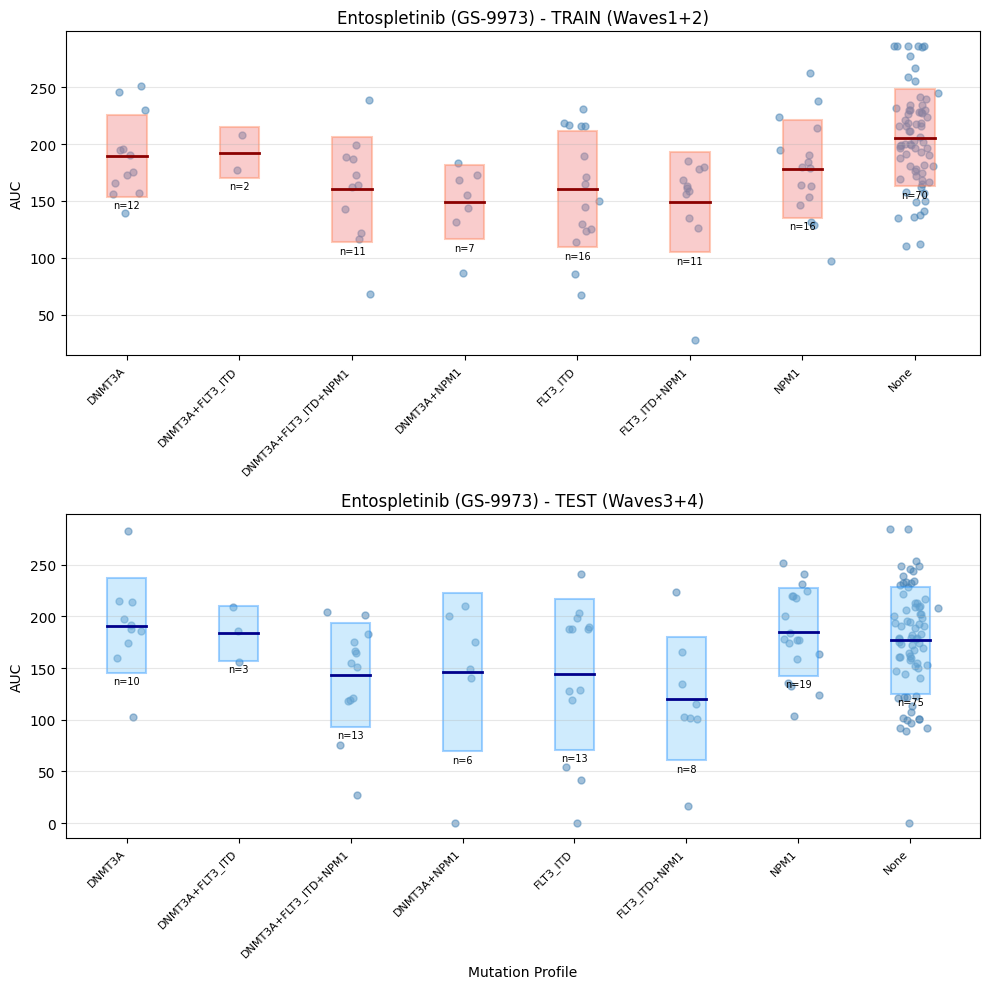

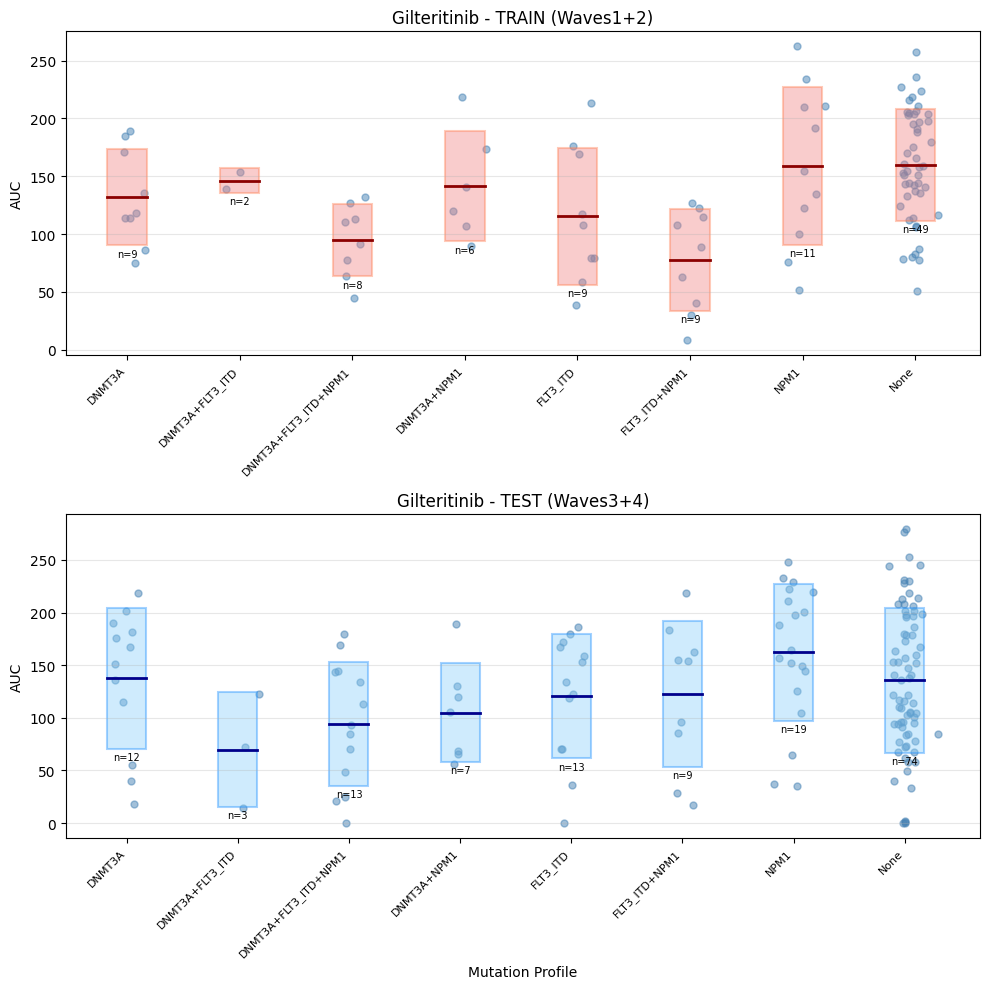

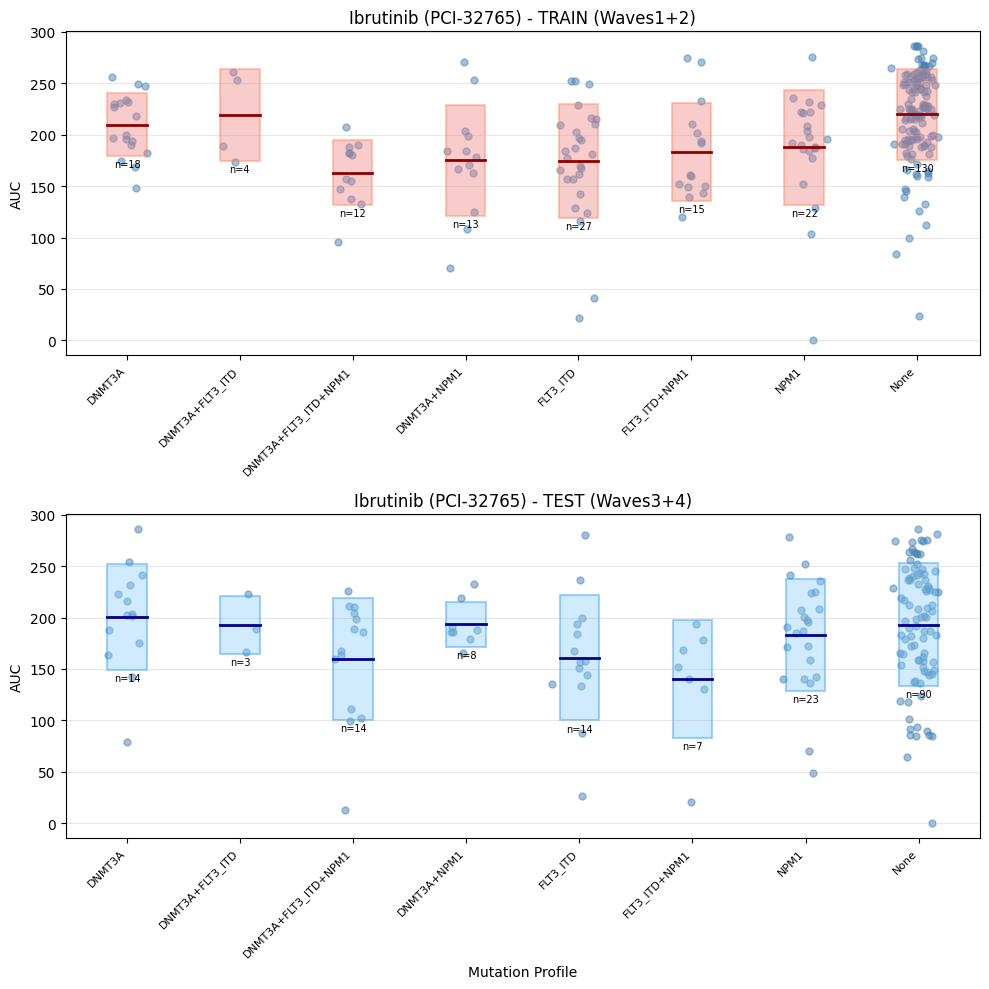

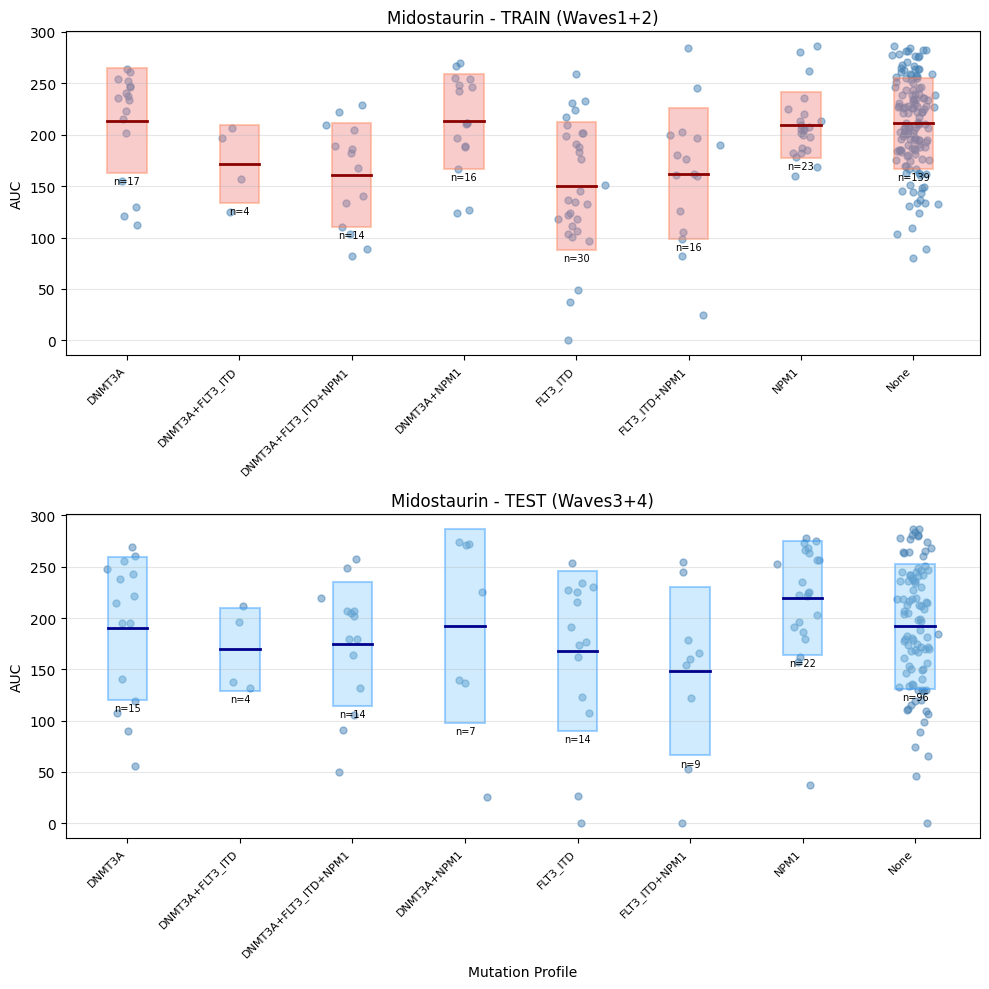

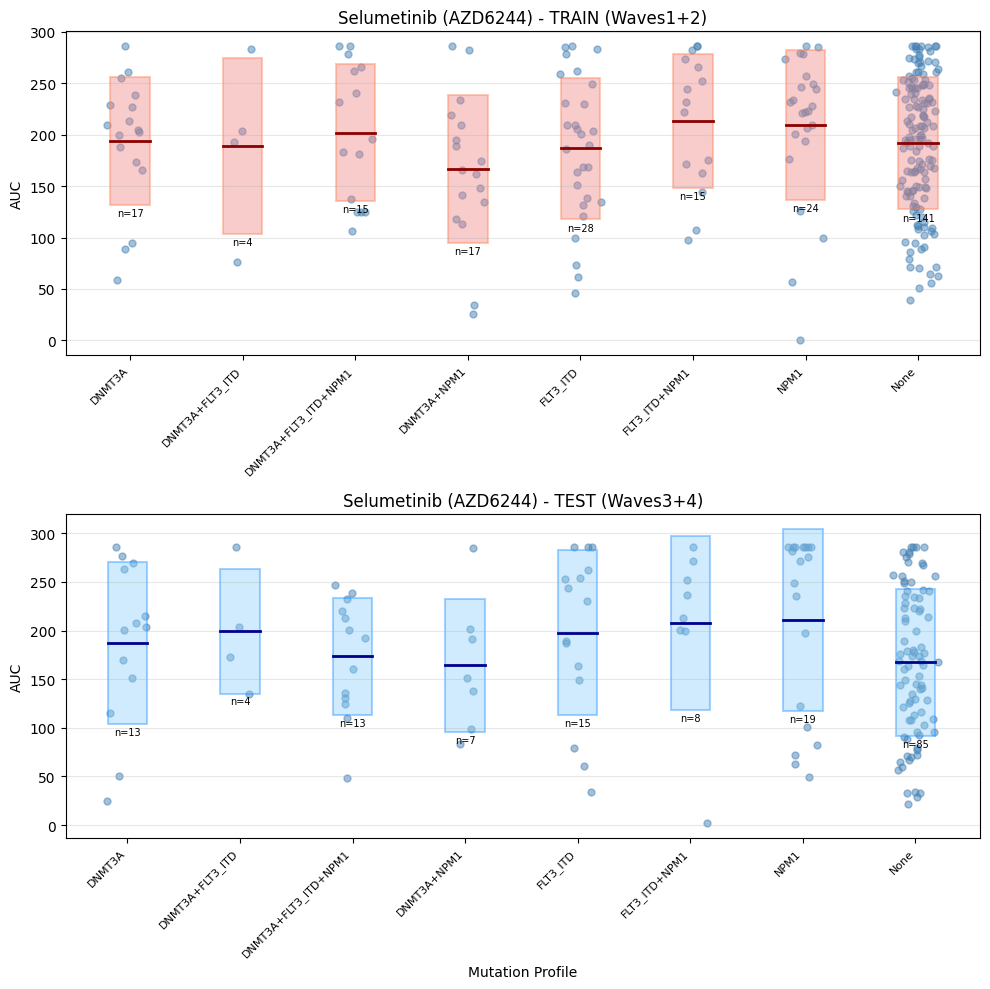

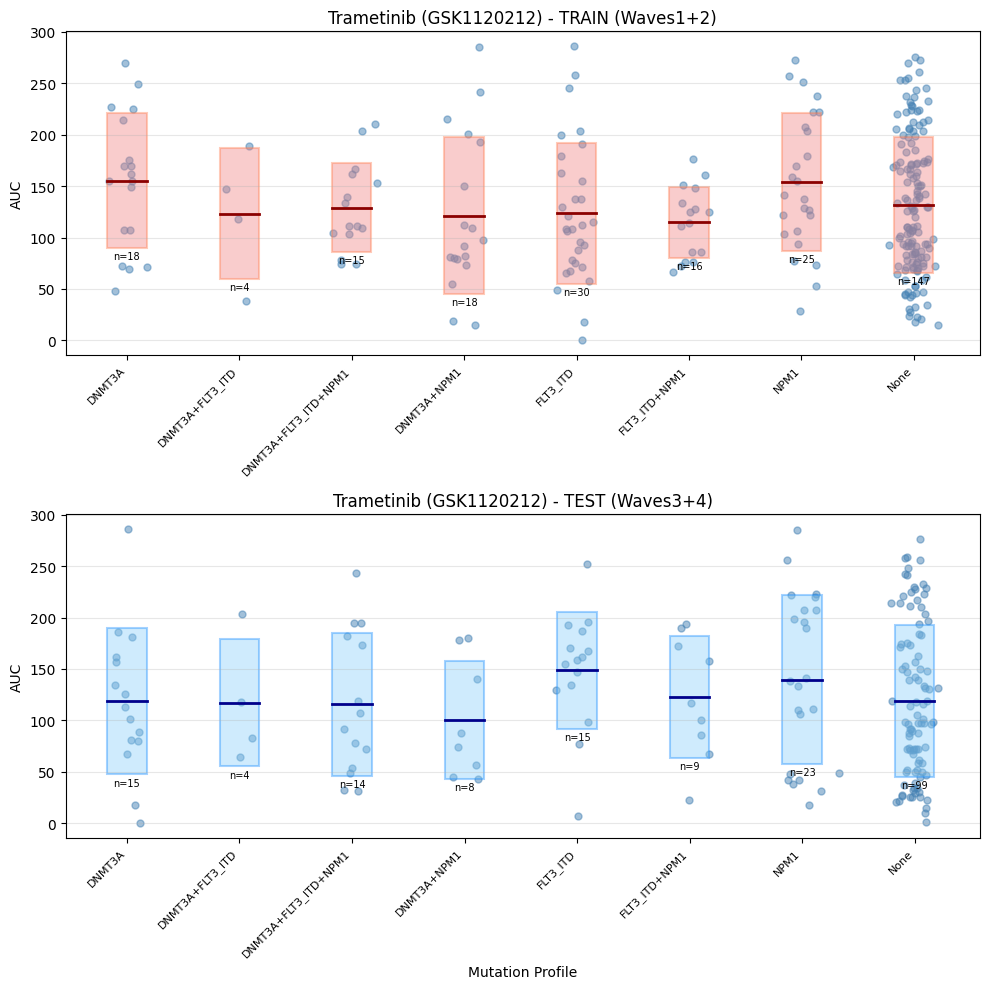

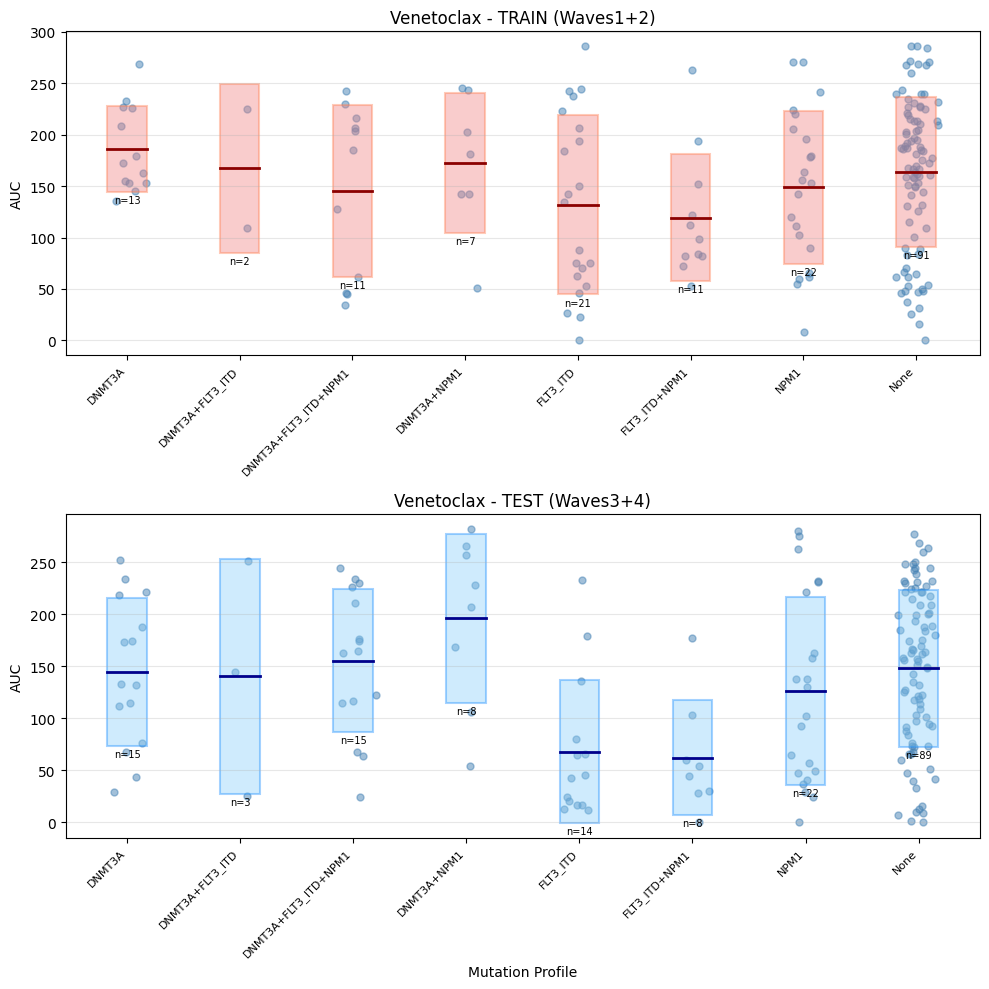

In [ ]:
# AUC by mutation profile with mean ± s.d. boxes (Train vs Test)

def normalize_profile_text(p):
    if isinstance(p, (set, frozenset, list, tuple)):
        genes = sorted(map(str, p))
    else:
        s = re.sub(r'[\{\}]', '', str(p))
        genes = sorted([g.strip() for g in s.split(',') if g.strip()])
    return "+".join(genes) if genes else "None"

# Merge cohort information
df_plot = df.copy()
df_plot["profile_label"] = df_plot["mutation_profile"].apply(normalize_profile_text)

# Create plots for each drug
for drug in sorted(df_plot["inhibitor"].unique()):
    sub = df_plot[df_plot["inhibitor"] == drug].copy()
    
    # Separate by cohort
    train_data = sub[sub['cohort'] == 'Waves1+2'].copy()
    test_data = sub[sub['cohort'] == 'Waves3+4'].copy()
    
    # Get profile statistics for both cohorts
    train_stats = train_data.groupby("profile_label")['auc'].agg(['mean', 'std', 'count']).reset_index()
    # train_stats = train_stats[train_stats['count'] >= 3]
    test_stats = test_data.groupby("profile_label")['auc'].agg(['mean', 'std', 'count']).reset_index()
    # test_stats = test_stats[test_stats['count'] >= 3]
    
    # Get union of profiles from both cohorts
    all_profiles = sorted(set(train_stats['profile_label'].tolist() + test_stats['profile_label'].tolist()))
    
    if len(all_profiles) == 0:
        continue
    
    # Create figure with 2 subplots (train on top, test on bottom)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(max(10, len(all_profiles) * 0.8), 10))
    
    positions = range(len(all_profiles))
    
    # Plot TRAIN data (Waves1+2) - TOP
    for i, profile in enumerate(all_profiles):
        profile_data = train_data[train_data['profile_label'] == profile]
        if len(profile_data) > 0:
            x_jitter = np.random.normal(i, 0.08, len(profile_data))
            ax1.scatter(x_jitter, profile_data['auc'], alpha=0.5, s=25, color='steelblue')
    
    # Plot mean ± s.d. boxes for train
    for i, profile in enumerate(all_profiles):
        stats = train_stats[train_stats['profile_label'] == profile]
        if len(stats) > 0:
            mean_val = stats['mean'].values[0]
            std_val = stats['std'].values[0]
            count = stats['count'].values[0]
            
            box_width = 0.35
            # Use facecolor and edgecolor separately to avoid warning
            ax1.add_patch(plt.Rectangle((i - box_width/2, mean_val - std_val), 
                                        box_width, 2*std_val, 
                                        facecolor='lightcoral', alpha=0.4, 
                                        linewidth=1.5, edgecolor='coral'))
            
            ax1.plot([i - box_width/2, i + box_width/2], [mean_val, mean_val], 
                    color='darkred', linewidth=2, zorder=10)
            
            ax1.text(i, mean_val - std_val - 3, f'n={int(count)}', 
                    ha='center', va='top', fontsize=7)
    
    ax1.set_xticks(positions)
    ax1.set_xticklabels(all_profiles, rotation=45, ha='right', fontsize=8)
    ax1.set_ylabel('AUC')
    ax1.set_title(f'{drug} - TRAIN (Waves1+2)')
    ax1.grid(axis='y', alpha=0.3)
    
    # Plot TEST data (Waves3+4) - BOTTOM
    for i, profile in enumerate(all_profiles):
        profile_data = test_data[test_data['profile_label'] == profile]
        if len(profile_data) > 0:
            x_jitter = np.random.normal(i, 0.08, len(profile_data))
            ax2.scatter(x_jitter, profile_data['auc'], alpha=0.5, s=25, color='steelblue')
    
    # Plot mean ± s.d. boxes for test
    for i, profile in enumerate(all_profiles):
        stats = test_stats[test_stats['profile_label'] == profile]
        if len(stats) > 0:
            mean_val = stats['mean'].values[0]
            std_val = stats['std'].values[0]
            count = stats['count'].values[0]
            
            box_width = 0.35
            ax2.add_patch(plt.Rectangle((i - box_width/2, mean_val - std_val), 
                                        box_width, 2*std_val, 
                                        facecolor='lightskyblue', alpha=0.4, 
                                        linewidth=1.5, edgecolor='dodgerblue'))
            
            ax2.plot([i - box_width/2, i + box_width/2], [mean_val, mean_val], 
                    color='darkblue', linewidth=2, zorder=10)
            
            ax2.text(i, mean_val - std_val - 3, f'n={int(count)}', 
                    ha='center', va='top', fontsize=7)
    
    ax2.set_xticks(positions)
    ax2.set_xticklabels(all_profiles, rotation=45, ha='right', fontsize=8)
    ax2.set_xlabel('Mutation Profile')
    ax2.set_ylabel('AUC')
    ax2.set_title(f'{drug} - TEST (Waves3+4)')
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Venetoclax - all waves
## Save as experiments.csv

The 8 mutation profiles (FLT3-ITD, NPM1, DNMT3A and their combinations) for 3 drugs: Venetoclax, Ibrutinib, Entospletinib.

In [14]:
# mutation class
classification = pd.read_csv("../input_files/Palma_class.csv")
gene_to_class = dict(zip(classification['symbol'], classification['class']))
gene_to_class

{'AKT1': 'oncogene',
 'BCL2': 'oncogene',
 'CCND1': 'oncogene',
 'CDKN2A': 'TSG',
 'CEBPA': 'TSG',
 'DNMT3A': 'TSG',
 'ETV6': 'TSG',
 'FBXW7': 'TSG',
 'FLT3': 'oncogene',
 'GSK3B': 'oncogene',
 'HOXA9': 'oncogene',
 'MAPK1': 'oncogene',
 'MEIS1': 'oncogene',
 'MYC': 'oncogene',
 'NPM1': 'TSG',
 'SOX4': 'oncogene',
 'STAT5A': 'oncogene',
 'TP53': 'TSG',
 'ATM': 'TSG',
 'CDKN1B': 'TSG',
 'CYCS': 'TSG',
 'MTOR': 'oncogene',
 'NRAS': 'oncogene',
 'PIK3CA': 'oncogene',
 'ROS1': 'oncogene'}

In [15]:
def create_experimental_data(df, cohort='Waves1+2',
                            mutation_genes=['FLT3_ITD', 'NPM1', 'DNMT3A'], 
                            inhibitors=['Venetoclax', 'Ibrutinib', 'Entospletinib'],
                            output_file='beataml_experiments.csv'):
    """
    Create experimental data CSV from BeatAML drug response data.
    
    Parameters:
    - df: DataFrame with mutation_profile, inhibitor, and auc columns
    - cohort: 'Waves1+2' or 'Waves3+4' or None
    - mutation_genes: List of genes
    - inhibitors: List of drug names
    - output_file: Output CSV filename
    
    Note: Oncogenes become Stimuli, TSGs become Inhibitors based on gene_to_class
    """
    
    # Drug to target mapping
    drug2target = {
        'Venetoclax': 'BCL2', 
        'Ibrutinib': 'BTK', 
        'Entospletinib': 'SYK'}
    
    # Normalize profile text for comparison
    def normalize_profile_text(p):
        if isinstance(p, (set, frozenset, list, tuple)):
            genes = sorted(map(str, p))
        else:
            s = re.sub(r'[\\{\\}]', '', str(p))
            genes = sorted([g.strip() for g in s.split(',') if g.strip()])
        return set(genes) if genes else set()
    
    df_work = df.copy()
    if cohort:
        df_work = df_work[df_work['cohort'] == cohort]
    df_work['profile_set'] = df_work['mutation_profile'].apply(normalize_profile_text)
    
    # Generate all mutation profile combinations
    from itertools import combinations
    all_profiles = []
    for r in range(len(mutation_genes) + 1):
        for combo in combinations(mutation_genes, r):
            all_profiles.append(set(combo))
    
    print(f"\\nGenerating data for {len(all_profiles)} profiles × {len(inhibitors)} drugs = {len(all_profiles) * len(inhibitors)} experiments")
    
    # Create experiment rows
    experiments = []
    exp_id = 1
    
    for profile in all_profiles:
        for drug in inhibitors:
            # Filter data for this profile and drug
            matching_data = df_work[
                (df_work['profile_set'] == profile) & 
                (df_work['inhibitor'].str.contains(drug, case=False, na=False))
            ]
            
            if len(matching_data) == 0:
                continue
            
            # Calculate average AUC
            avg_auc = matching_data['auc'].mean()
            std_auc = matching_data['auc'].std()
            n_patients = len(matching_data)
            
            # Classify genes as oncogenes or TSGs
            oncogenes = []
            tsgs = []
            
            for gene in profile:
                if gene == 'FLT3_ITD':
                    gene = 'FLT3'
                gene_class = gene_to_class.get(gene, 'unknown')
                if gene_class == 'oncogene':
                    oncogenes.append(gene)
                elif gene_class == 'TSG':
                    tsgs.append(gene)
                else:
                    print(f"Warning: Unknown classification for {gene}, treating as oncogene")
                    oncogenes.append(gene)
            
            # Oncogenes → Stimuli (activate)
            stimuli = ','.join(sorted(oncogenes)) if oncogenes else ''
            stimuli_efficacy = ','.join(['1'] * len(oncogenes)) if oncogenes else ''
            
            # TSGs + Drug target → Inhibitors (knockdown)
            target = drug2target.get(drug, '')
            if not target:
                print(f"Warning: No target mapping for {drug}, skipping...")
                continue
            
            all_inhibitors = sorted(tsgs + [target])
            inhibitors_str = ','.join(all_inhibitors)
            inhibitors_efficacy = ','.join(['1'] * len(all_inhibitors))
            
            measured_nodes = 'AUC'
            measured_values = f'{avg_auc:.2f}'
            
            experiments.append({
                'Experiments': exp_id,
                'Stimuli': stimuli,
                'Stimuli_efficacy': stimuli_efficacy,
                'Inhibitors': inhibitors_str,
                'Inhibitors_efficacy': inhibitors_efficacy,
                'Measured_nodes': measured_nodes,
                'Measured_values': measured_values,
                'n_patients': n_patients,
                'std': f'{std_auc:.2f}',
                'drug': drug
            })
            
            exp_id += 1
    
    # Create DataFrame
    exp_df = pd.DataFrame(experiments)
    
    # Save to CSV
    exp_df_save = exp_df[['Experiments', 'Stimuli', 'Stimuli_efficacy', 
                           'Inhibitors', 'Inhibitors_efficacy', 
                           'Measured_nodes', 'Measured_values']].copy()
    exp_df_save.to_csv(output_file, index=False)
    
    print(f"\\nSaved {len(exp_df)} experiments to {output_file}")
    print(f"\\nSummary by drug:")
    print(exp_df.groupby('drug').agg({
        'n_patients': 'sum',
        'Measured_values': lambda x: f"{pd.to_numeric(x).mean():.2f}±{pd.to_numeric(x).std():.2f}"
    }).rename(columns={'Measured_values': 'Mean AUC±SD', 'n_patients': 'Total patients'}))
    
    return exp_df

In [ ]:
# Create experimental data for Venetoclax
exp_data = create_experimental_data(
    df, 
    mutation_genes=['FLT3_ITD', 'NPM1', 'DNMT3A'],
    # inhibitors=['Venetoclax', 'Ibrutinib', 'Entospletinib'],
    inhibitors=['Venetoclax'],
    # output_file='../data/BeatAML_AUC_Venetoclax+Ibrutinib+Entospletinib.csv'
    output_file='../data/BeatAML_AUC_Venetoclax.csv'
)

exp_data

\nGenerating data for 8 profiles × 1 drugs = 8 experiments
\nSaved 8 experiments to ../data/BeatAML_AUC_Venetoclax.csv
\nSummary by drug:
            Total patients   Mean AUC±SD
drug                                    
Venetoclax             352  143.25±29.71


,Experiments,Stimuli,Stimuli_efficacy,Inhibitors,Inhibitors_efficacy,Measured_nodes,Measured_values,n_patients,std,drug
0,1,,,BCL2,1,AUC,155.79,180,74.36,Venetoclax
1,2,FLT3,1,BCL2,1,AUC,106.12,35,85.32,Venetoclax
2,3,,,"BCL2,NPM1","1,1",AUC,137.37,44,82.65,Venetoclax
3,4,,,"BCL2,DNMT3A","1,1",AUC,163.84,28,62.12,Venetoclax
4,5,FLT3,1,"BCL2,NPM1","1,1",AUC,95.32,19,64.62,Venetoclax
5,6,FLT3,1,"BCL2,DNMT3A","1,1",AUC,151.24,5,91.16,Venetoclax
6,7,,,"BCL2,DNMT3A,NPM1","1,1,1",AUC,185.21,15,73.77,Venetoclax
7,8,FLT3,1,"BCL2,DNMT3A,NPM1","1,1,1",AUC,151.12,26,73.91,Venetoclax


## Extend PBN for drug targets
- Venetoclax	BCL2  
- Ibrutinib	BTK  
- Entospletinib	SYK  

In [130]:
# extended PBN by adding BCL2
network = BNMPy.load_network(network_file_no_phenotype)
genes = list(network.nodeDict.keys())
# genes = genes + ['BCL2','SYK', 'BTK']
genes = genes + ['BCL2']
KG_string, relations = BNMPy.load_signor_network(genes, joiner='&')
KG = BNMPy.load_network_from_string(KG_string)
pbn_string = BNMPy.merge_networks([network, KG], method="PBN", prob=0.6)
pbn = BNMPy.load_pbn_from_string(pbn_string)
print(pbn_string)

No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.
number of genes found: 19
[2322, 4869, 207, 596, 595, 1029, 1050, 1788, 5594, 2120, 55294, 2932, 3205, 4211, 4609, 6659, 6776, 7157, 596]
No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.
No initial state provided, using a random initial state
PBN loaded successfully. There are 18 genes in the network.
AKT1 = AKT1 & FLT3, 0.4
AKT1 = FLT3, 0.6
BCL2 = !GSK3B & MAPK1 & !TP53, 0.4
BCL2 = MAPK1 & !TP53, 0.6
CCND1 = ! ( DNMT3A | GSK3B ), 0.6
CCND1 = !DNMT3A & !GSK3B & MYC, 0.4
CDKN2A = !DNMT3A & !MYC, 0.4
CDKN2A = NPM1, 0.6
CEBPA = !FLT3, 0.6
CEBPA = CEBPA & !FLT3 & GSK3B & !MAPK1, 0.4
DNMT3A = DNMT3A, 0.6
DNMT3A = MYC & STAT5A, 0.4
ETV6 = !MAPK1, 1.0
FBXW7 = AKT1 & NPM1, 0.4
FBXW7 = NPM1, 0.6
FLT3 = FLT3, 1.0
GSK3B = !AKT1 & GSK3B & !MAPK1, 0.4
GSK3B = !AKT1, 0.6
HOXA9 = !DNMT3A & !NPM1, 0.4
HOXA9 = !NPM

In [131]:
# Three alternative networks
KG_OR_string, relations = BNMPy.load_signor_network(genes, joiner='|')
KG_AND_string, relations = BNMPy.load_signor_network(genes, joiner='&')
KG_IW_string, relations = BNMPy.load_signor_network(genes, joiner='inhibitor_wins')

KG_OR = BNMPy.load_network_from_string(KG_OR_string)
KG_AND = BNMPy.load_network_from_string(KG_AND_string)
KG_IW = BNMPy.load_network_from_string(KG_IW_string)

pbn_string = BNMPy.merge_networks([network, KG_OR, KG_AND, KG_IW], method="PBN", prob=0.25)
pbn = BNMPy.load_pbn_from_string(pbn_string)
print(pbn_string)

number of genes found: 19
[2322, 4869, 207, 596, 595, 1029, 1050, 1788, 5594, 2120, 55294, 2932, 3205, 4211, 4609, 6659, 6776, 7157, 596]
number of genes found: 19
[2322, 4869, 207, 596, 595, 1029, 1050, 1788, 5594, 2120, 55294, 2932, 3205, 4211, 4609, 6659, 6776, 7157, 596]
number of genes found: 19
[2322, 4869, 207, 596, 595, 1029, 1050, 1788, 5594, 2120, 55294, 2932, 3205, 4211, 4609, 6659, 6776, 7157, 596]
No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.
No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.
No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.
No initial state provided, using a random initial state
PBN loaded successfully. There are 18 genes in the network.
AKT1 = AKT1 & FLT3, 0.25
AKT1 = AKT1 | FLT3, 0.5
AKT1 = FLT3, 0.25
BCL2 = !GSK3B & MAPK1 & !TP53, 0.5
BCL2 = !

In [132]:
# get phenotype score formula
formula = BNMPy.phenotype_scores(
    genes=genes,
    simulation_results=None,
    phenotypes=['APOPTOSIS']
)
formula

Path found for 1 phenotypes: ['APOPTOSIS']


{'APOPTOSIS': '- AKT1 -  BCL2 + CDKN2A + GSK3B -  MAPK1 -  MEIS1 -  STAT5A + TP53'}

## Run optimization

In [22]:
# optimizer configuration
config = {
    'pso_params': {
        'n_particles': 100,  # 20*number of parameters to optimize
        'iters': 2000,
        'options': {
            'c1': 0.5, # Cognitive parameter
            'c2': 0.3, # Social parameter
            'w': 0.9 # Inertia weight
        },
        'ftol': -1,
        'ftol_iter': 5
    },
    'de_params': {
        'strategy': 'best1bin',
        'maxiter': 1000,
        'popsize': 20,
        'tol': 0.001, 
        'atol': 0,
        'mutation': (0.5, 1.5),
        'recombination': 0.7,
        'seed': None,
        'disp': False,
        'init': 'sobol',
        'updating': 'deferred',
        'workers': -1,
        'early_stopping': False  # Control early stopping
    },
    'steady_state': {
        'method': 'tsmc',
            'tsmc_params': {
                'epsilon': 0.05, # range of transition probability [Default=0.001]
                'r': 0.1, # range of accuracy (most sensitive) [Default=0.025]
                's': 0.85, # probability to acquire defined accuracy [Default=0.95]
                'p_mir': 0.01, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
                'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
                'max_iterations': 1000, # maximum convergence iterations [Default=5000]
                'freeze_constant': True # whether to treat self-loop as a fixed node
            },
    },
    'max_try': 3,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.1, # threshold for accepting fit,
    'seed': 9
}

In [127]:
# AND
optimizer = BNMPy.ParameterOptimizer(pbn, '../data/BeatAML_AUC_Venetoclax.csv', 
    config=config, 
    nodes_to_optimize=None, 
    Measured_formula='- AKT1 - BCL2 + CDKN2A + GSK3B - MAPK1 - MEIS1 - STAT5A + TP53',
    normalize=True,
    verbose=False)

# Run optimization
result = optimizer.optimize(method='differential_evolution')

Normalization enabled: Measured values range [95.3200, 185.2100] scaled to [0, 1]

Optimization attempt 1/3
Running DE optimization...


[██████████████████████████████] 100.0% | Iter: 1000/1000 | Best MSE: 0.049609 | Conv: 0.0805

--- Optimization finished. Best MSE found: 0.049609 ---

--- Optimized PBN Rules ---
AKT1 = AKT1 & FLT3, 0.5409
AKT1 = FLT3, 0.4591
BCL2 = !GSK3B & MAPK1 & !TP53, 0.7987
BCL2 = MAPK1 & !TP53, 0.2013
CCND1 = ! ( DNMT3A | GSK3B ), 0.0123
CCND1 = !DNMT3A & !GSK3B & MYC, 0.9877
CDKN2A = !DNMT3A & !MYC, 0.9462
CDKN2A = NPM1, 0.0538
CEBPA = !FLT3, 0.8680
CEBPA = CEBPA & !FLT3 & GSK3B & !MAPK1, 0.1320
DNMT3A = DNMT3A, 0.7511
DNMT3A = MYC & STAT5A, 0.2489
ETV6 = !MAPK1, 1.0000
FBXW7 = AKT1 & NPM1, 0.9529
FBXW7 = NPM1, 0.0471
FLT3 = FLT3, 1.0000
GSK3B = !AKT1 & GSK3B & !MAPK1, 0.0344
GSK3B = !AKT1, 0.9656
HOXA9 = !DNMT3A & !NPM1, 0.0100
HOXA9 = !NPM1, 0.9900
MAPK1 = AKT1 & MAPK1, 0.1370
MAPK1 = FLT3, 0.8630
MEIS1 = !DNMT3A & HOXA9, 1.0000
MYC = !CEBPA & !FBXW7 & FLT3

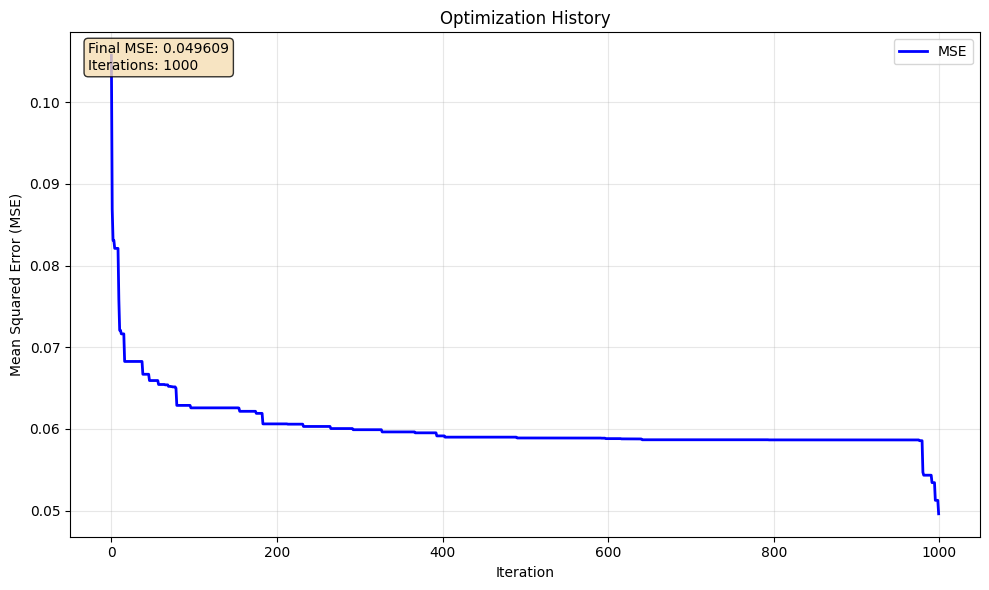

In [128]:
optimizer.plot_optimization_history(result)

Simulating optimized model on all experimental conditions...
  Experiment 1: Formula measurement (predicted=-0.6500, measured=155.7900)
  Experiment 2: Formula measurement (predicted=-0.6100, measured=106.1200)
  Experiment 3: Formula measurement (predicted=-0.7335, measured=137.3700)
  Experiment 4: Formula measurement (predicted=-0.3100, measured=163.8400)
  Experiment 5: Formula measurement (predicted=-0.9600, measured=95.3200)
  Experiment 6: Formula measurement (predicted=-0.4500, measured=151.2400)
  Experiment 7: Formula measurement (predicted=-0.0800, measured=185.2100)
  Experiment 8: Formula measurement (predicted=-0.0100, measured=151.1200)
Simulation completed: 8 data points
Plot saved to BeatAML_AUC_Venetoclax_AND/prediction_vs_experimental.png
Residual plot saved to BeatAML_AUC_Venetoclax_AND/residual_analysis.png
Evaluation report saved to BeatAML_AUC_Venetoclax_AND/evaluation_report.txt
Results exported to BeatAML_AUC_Venetoclax_AND/detailed_results.csv
Optimized PBN sa

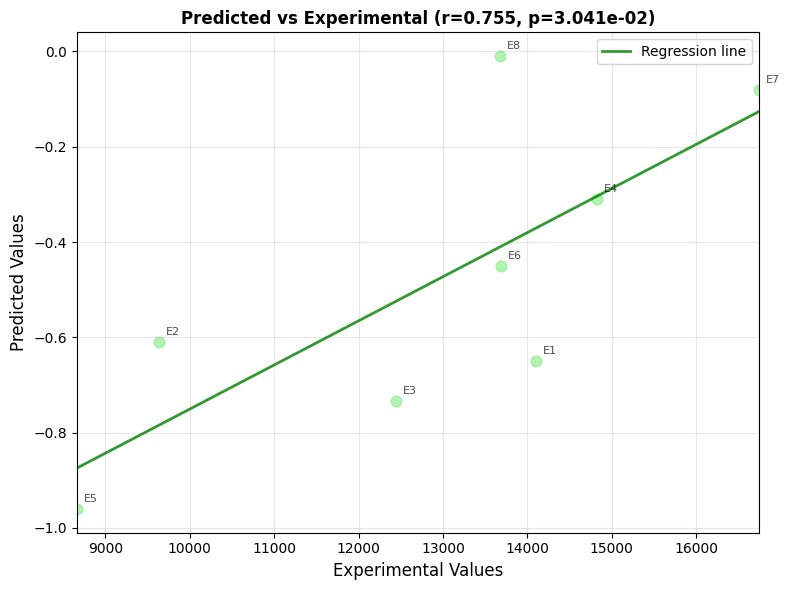

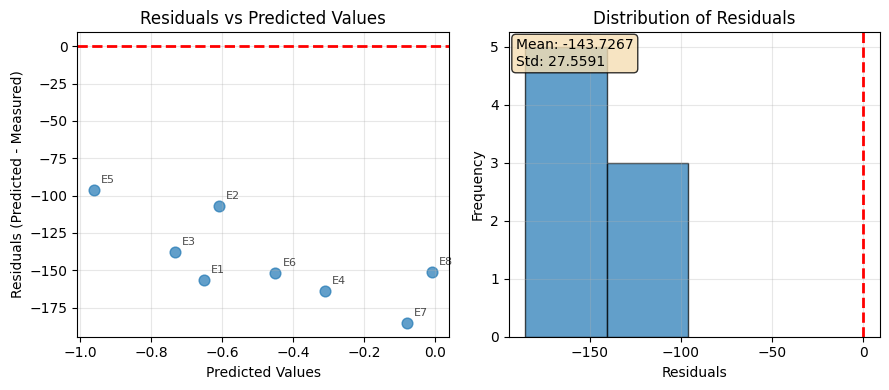

In [129]:
np.random.seed(9)
output_dir = "BeatAML_AUC_Venetoclax_AND"
evaluator = BNMPy.evaluate_optimization_result(
    result, 
    optimizer, 
    output_dir=output_dir,
    plot_residuals=True,
    save=True,
    detailed=True,
    figsize=(8, 6)
)

In [134]:
# AND + OR + IW
optimizer = BNMPy.ParameterOptimizer(pbn, '../data/BeatAML_AUC_Venetoclax.csv', 
    config=config, 
    nodes_to_optimize=None, 
    Measured_formula='- AKT1 - BCL2 + CDKN2A + GSK3B - MAPK1 - MEIS1 - STAT5A + TP53',
    normalize=True,
    verbose=False)

# Run optimization
result = optimizer.optimize(method='differential_evolution')

Normalization enabled: Measured values range [95.3200, 185.2100] scaled to [0, 1]

Optimization attempt 1/3
Running DE optimization...


[██████████████████████████████] 100.0% | Iter: 1000/1000 | Best MSE: 0.002309 | Conv: 0.0027

--- Optimization finished. Best MSE found: 0.002309 ---

--- Optimized PBN Rules ---
AKT1 = AKT1 & FLT3, 0.4373
AKT1 = AKT1 | FLT3, 0.4107
AKT1 = FLT3, 0.1520
BCL2 = !GSK3B & MAPK1 & !TP53, 0.1445
BCL2 = !GSK3B | MAPK1 | !TP53, 0.7829
BCL2 = MAPK1 & !TP53, 0.0726
CCND1 = ! ( DNMT3A | GSK3B ), 0.3948
CCND1 = !DNMT3A & !GSK3B & MYC, 0.1327
CCND1 = !DNMT3A | !GSK3B | MYC, 0.4725
CDKN2A = !DNMT3A & !MYC, 0.1114
CDKN2A = !DNMT3A | !MYC, 0.3603
CDKN2A = NPM1, 0.5283
CEBPA = !FLT3 & !MAPK1 & ( CEBPA | GSK3B ), 0.0645
CEBPA = !FLT3, 0.5547
CEBPA = CEBPA & !FLT3 & GSK3B & !MAPK1, 0.3401
CEBPA = CEBPA | !FLT3 | GSK3B | !MAPK1, 0.0406
DNMT3A = DNMT3A, 0.0607
DNMT3A = MYC & STAT5A, 0.2364
DNMT3A = MYC | STAT5A, 0.7028
ETV6 = !MAPK1, 1.0000
FBXW7 = AKT1 & NPM1, 0.2373
FB

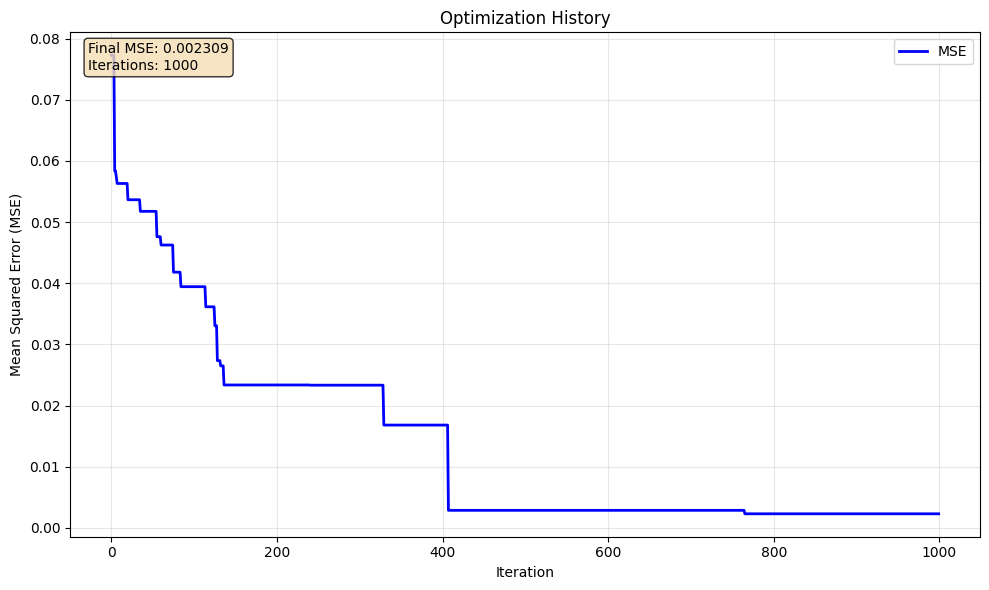

In [135]:
optimizer.plot_optimization_history(result)

Simulating optimized model on all experimental conditions...
  Experiment 1: Formula measurement (predicted=-1.1284, measured=155.7900)
  Experiment 2: Formula measurement (predicted=-1.2900, measured=106.1200)
  Experiment 3: Formula measurement (predicted=-1.1949, measured=137.3700)
  Experiment 4: Formula measurement (predicted=-1.0900, measured=163.8400)
  Experiment 5: Formula measurement (predicted=-1.3200, measured=95.3200)
  Experiment 6: Formula measurement (predicted=-1.1186, measured=151.2400)
  Experiment 7: Formula measurement (predicted=-1.0000, measured=185.2100)
  Experiment 8: Formula measurement (predicted=-1.1000, measured=151.1200)
Simulation completed: 8 data points
Plot saved to BeatAML_AUC_Venetoclax_AND+OR+IW/prediction_vs_experimental.png
Residual plot saved to BeatAML_AUC_Venetoclax_AND+OR+IW/residual_analysis.png
Evaluation report saved to BeatAML_AUC_Venetoclax_AND+OR+IW/evaluation_report.txt
Results exported to BeatAML_AUC_Venetoclax_AND+OR+IW/detailed_resu

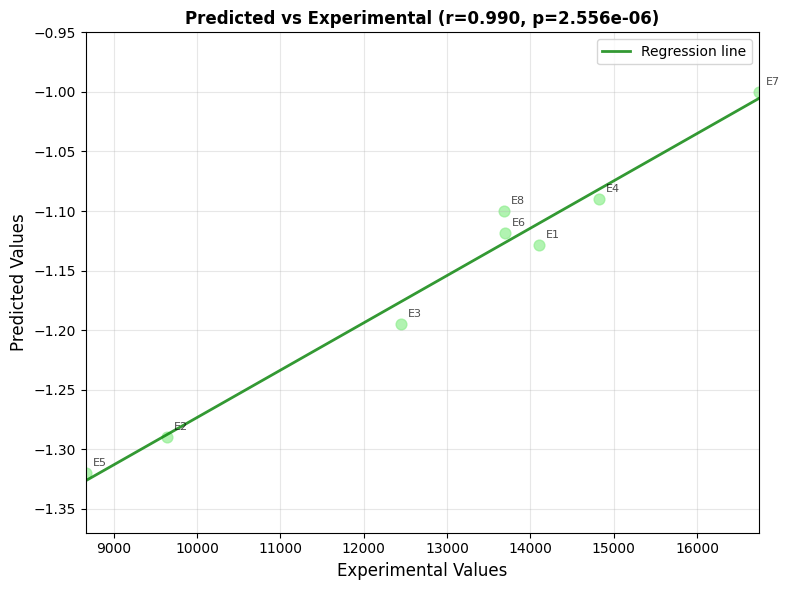

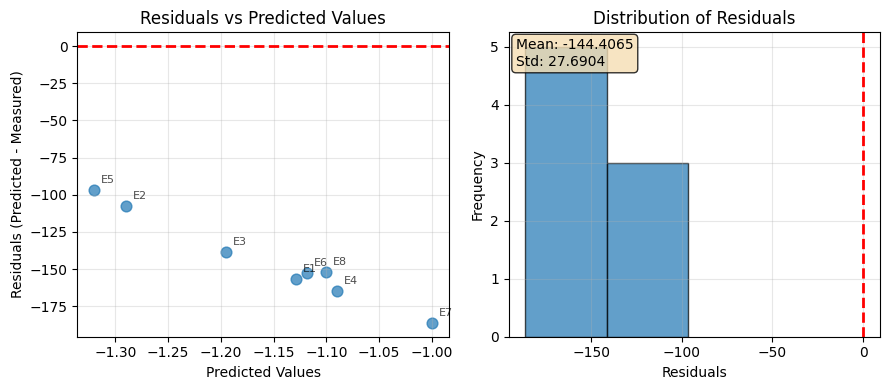

In [136]:
np.random.seed(9)
output_dir = "BeatAML_AUC_Venetoclax_AND+OR+IW"
evaluator = BNMPy.evaluate_optimization_result(
    result, 
    optimizer, 
    output_dir=output_dir,
    plot_residuals=True,
    save=True,
    detailed=True,
    figsize=(8, 6)
)

# Venetoclax, Ibrutinib, Entospletinib
- Venetoclax	BCL2  
- Ibrutinib	BTK  
- Entospletinib	SYK  

In [138]:
# Create experimental data for drugs
exp_data = create_experimental_data(
    df, 
    mutation_genes=['FLT3_ITD', 'NPM1', 'DNMT3A'],
    inhibitors=['Venetoclax', 'Ibrutinib', 'Entospletinib'],
    output_file='../data/BeatAML_AUC_Venetoclax+Ibrutinib+Entospletinib.csv'
)

exp_data

\nGenerating data for 8 profiles × 3 drugs = 24 experiments
\nSaved 24 experiments to ../data/BeatAML_AUC_Venetoclax+Ibrutinib+Entospletinib.csv
\nSummary by drug:
               Total patients   Mean AUC±SD
drug                                       
Entospletinib             292  167.33±22.31
Ibrutinib                 414  186.34±19.02
Venetoclax                352  143.25±29.71


,Experiments,Stimuli,Stimuli_efficacy,Inhibitors,Inhibitors_efficacy,Measured_nodes,Measured_values,n_patients,std,drug
0,1,,,BCL2,1,AUC,155.79,180,74.36,Venetoclax
1,2,,,BTK,1,AUC,208.86,220,52.76,Ibrutinib
2,3,,,SYK,1,AUC,190.90,145,49.58,Entospletinib
3,4,FLT3,1,BCL2,1,AUC,106.12,35,85.32,Venetoclax
4,5,FLT3,1,BTK,1,AUC,169.87,41,57.04,Ibrutinib
5,6,FLT3,1,SYK,1,AUC,152.86,29,61.20,Entospletinib
6,7,,,"BCL2,NPM1","1,1",AUC,137.37,44,82.65,Venetoclax
7,8,,,"BTK,NPM1","1,1",AUC,185.31,45,54.35,Ibrutinib
8,9,,,"NPM1,SYK","1,1",AUC,181.86,35,42.07,Entospletinib
9,10,,,"BCL2,DNMT3A","1,1",AUC,163.84,28,62.12,Venetoclax


In [2]:
# extended PBN by adding BCL2
network = BNMPy.load_network(network_file_no_phenotype)
genes = list(network.nodeDict.keys())
genes = genes + ['BCL2','SYK', 'BTK']
KG_string, relations = BNMPy.load_signor_network(genes, joiner='&')
KG = BNMPy.load_network_from_string(KG_string)
pbn_string = BNMPy.merge_networks([network, KG], method="PBN", prob=0.6)
pbn = BNMPy.load_pbn_from_string(pbn_string)
print(pbn_string)

No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.
number of genes found: 21
[2322, 4869, 207, 596, 595, 1029, 1050, 1788, 5594, 2120, 55294, 2932, 3205, 4211, 4609, 6659, 6776, 7157, 596, 6850, 695]
No initial state provided, using a random initial state
Network loaded successfully. There are 20 genes in the network.
No initial state provided, using a random initial state
PBN loaded successfully. There are 20 genes in the network.
AKT1 = AKT1 & FLT3, 0.4
AKT1 = FLT3, 0.6
BCL2 = !GSK3B & MAPK1 & !TP53, 0.4
BCL2 = MAPK1 & !TP53, 0.6
BTK = !AKT1 & BTK & SYK, 1.0
CCND1 = ! ( DNMT3A | GSK3B ), 0.6
CCND1 = !DNMT3A & !GSK3B & MYC, 0.4
CDKN2A = !DNMT3A & !MYC, 0.4
CDKN2A = NPM1, 0.6
CEBPA = !FLT3, 0.6
CEBPA = CEBPA & !FLT3 & GSK3B & !MAPK1, 0.4
DNMT3A = DNMT3A, 0.6
DNMT3A = MYC & STAT5A, 0.4
ETV6 = !MAPK1, 1.0
FBXW7 = AKT1 & NPM1, 0.4
FBXW7 = NPM1, 0.6
FLT3 = FLT3 & SYK, 0.4
FLT3 = FLT3, 0.6
GSK3B = !AKT1 & GSK3B & !MAPK1, 0

In [5]:
# optimizer configuration
config = {
    'de_params': {
        'strategy': 'best1bin',
        'maxiter': 500,
        'popsize': 40,
        'tol': 0.001, 
        'atol': 0,
        'mutation': (0.5, 1.5),
        'recombination': 0.7,
        'seed': None,
        'disp': False,
        'init': 'sobol',
        'updating': 'deferred',
        'workers': -1,
        'early_stopping': False  # Control early stopping
    },
    'steady_state': {
        'method': 'tsmc',
            'tsmc_params': {
                'epsilon': 0.05, # range of transition probability [Default=0.001]
                'r': 0.1, # range of accuracy (most sensitive) [Default=0.025]
                's': 0.85, # probability to acquire defined accuracy [Default=0.95]
                'p_mir': 0.01, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
                'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
                'max_iterations': 1000, # maximum convergence iterations [Default=5000]
                'freeze_constant': True # whether to treat self-loop as a fixed node
            },
    },
    'max_try': 3,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.1, # threshold for accepting fit,
    'seed': 9,
    'display_rules_every': 100
}

In [6]:
# AND
optimizer = BNMPy.ParameterOptimizer(pbn, '../data/BeatAML_AUC_Venetoclax+Ibrutinib+Entospletinib.csv', 
    config=config, 
    nodes_to_optimize=None, 
    Measured_formula='- AKT1 - BCL2 + CDKN2A + GSK3B - MAPK1 - MEIS1 - STAT5A + TP53',
    normalize=True,
    verbose=False)

# Run optimization
result = optimizer.optimize(method='differential_evolution')

Normalization enabled: Measured values range [95.3200, 208.8600] scaled to [0, 1]

Optimization attempt 1/3
Running DE optimization...




                                                                                                                        

--- Optimization finished. Best MSE found: 0.052504 ---

--- Optimized PBN Rules ---
AKT1 = AKT1 & FLT3, 0.9937
AKT1 = FLT3, 0.0063
BCL2 = !GSK3B & MAPK1 & !TP53, 0.9627
BCL2 = MAPK1 & !TP53, 0.0373
BTK = !AKT1 & BTK & SYK, 1.0000
CCND1 = ! ( DNMT3A | GSK3B ), 0.3523
CCND1 = !DNMT3A & !GSK3B & MYC, 0.6477
CDKN2A = !DNMT3A & !MYC, 0.9172
CDKN2A = NPM1, 0.0828
CEBPA = !FLT3, 0.9736
CEBPA = CEBPA & !FLT3 & GSK3B & !MAPK1, 0.0264
DNMT3A = DNMT3A, 0.5051
DNMT3A = MYC & STAT5A, 0.4949
ETV6 = !MAPK1, 1.0000
FBXW7 = AKT1 & NPM1, 0.7143
FBXW7 = NPM1, 0.2857
FLT3 = FLT3 & SYK, 0.5692
FLT3 = FLT3, 0.4308
GSK3B = !AKT1 & GSK3B & !MAPK1, 0.2317
GSK3B = !AKT1, 0.7683
HOXA9 = !DNMT3A & !NPM1, 0.8836
HOXA9 = !NPM1, 0.1164
MAPK1 = AKT1 & MAPK1, 0.3304
MAPK1 = FLT3, 0.6696
MEIS1 = !DNMT3A & HOXA9, 1.0000
MYC = !CEBPA & !FBXW7 & FLT3 & !GSK3B & MAPK1, 0.0108
MYC = MAPK1 & ( !FBXW7 | !

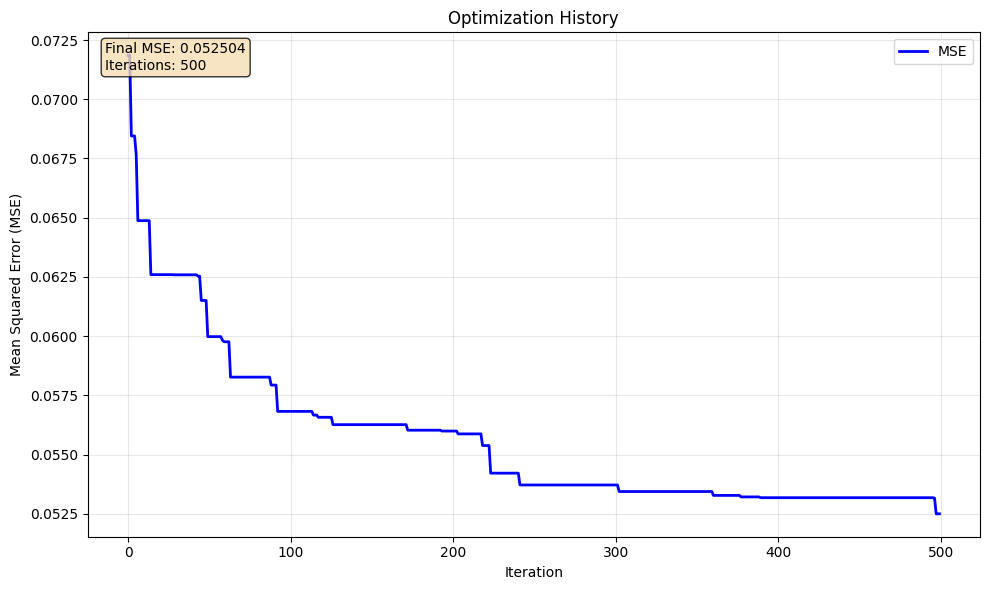

In [7]:
optimizer.plot_optimization_history(result)

Simulating optimized model on all experimental conditions...
  Experiment 1: Formula measurement (predicted=-0.3500, measured=155.7900)
  Experiment 2: Formula measurement (predicted=1.9200, measured=208.8600)
  Experiment 3: Formula measurement (predicted=1.9500, measured=190.9000)
  Experiment 4: Formula measurement (predicted=-0.7400, measured=106.1200)
  Experiment 5: Formula measurement (predicted=-0.4940, measured=169.8700)
  Experiment 6: Formula measurement (predicted=-0.8699, measured=152.8600)
  Experiment 7: Formula measurement (predicted=-1.1100, measured=137.3700)
  Experiment 8: Formula measurement (predicted=1.6200, measured=185.3100)
  Experiment 9: Formula measurement (predicted=1.3500, measured=181.8600)
  Experiment 10: Formula measurement (predicted=-0.9300, measured=163.8400)
  Experiment 11: Formula measurement (predicted=1.4700, measured=205.6800)
  Experiment 12: Formula measurement (predicted=1.2809, measured=190.3400)
  Experiment 13: Formula measurement (pred

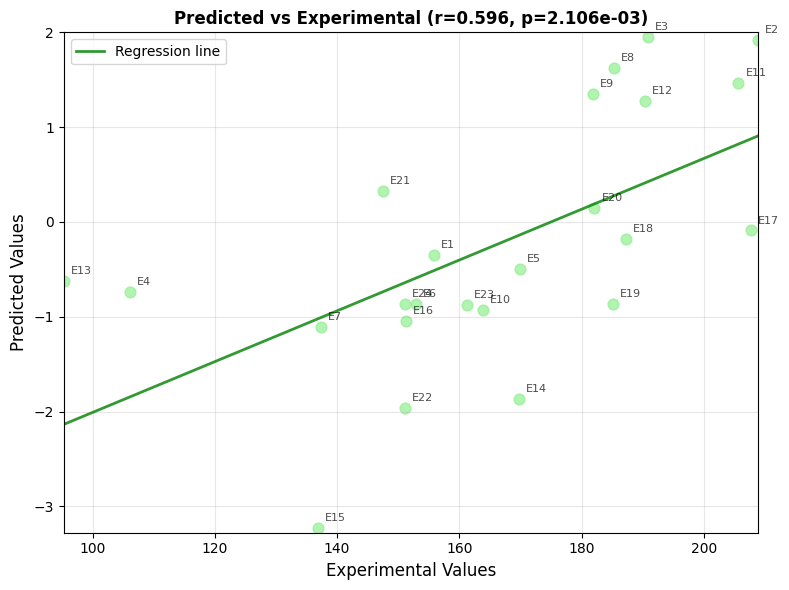

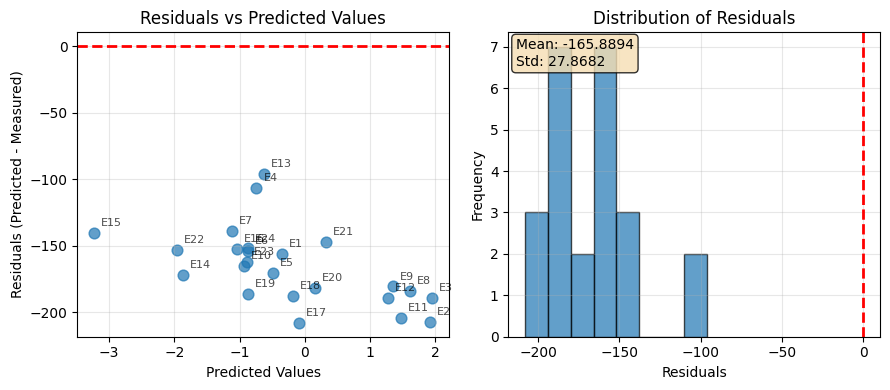

In [8]:
np.random.seed(9)
output_dir = "BeatAML_AUC_Venetoclax+Ibrutinib+Entospletinib_AND"
evaluator = BNMPy.evaluate_optimization_result(
    result, 
    optimizer, 
    output_dir=output_dir,
    plot_residuals=True,
    save=True,
    detailed=True,
    figsize=(8, 6)
)

# Venetoclax - train on Waves1+2, test on Waves3+4

In [20]:
# Create experimental data for Venetoclax - Waves1+2
exp_data = create_experimental_data(
    df, 
    cohort='Waves1+2',
    mutation_genes=['FLT3_ITD', 'NPM1', 'DNMT3A'],
    # inhibitors=['Venetoclax', 'Ibrutinib', 'Entospletinib'],
    inhibitors=['Venetoclax'],
    # output_file='../data/BeatAML_AUC_Venetoclax+Ibrutinib+Entospletinib.csv'
    output_file='../data/BeatAML_AUC_Venetoclax_Waves1+2.csv'
)

exp_data

\nGenerating data for 8 profiles × 1 drugs = 8 experiments
\nSaved 8 experiments to ../data/BeatAML_AUC_Venetoclax_Waves1+2.csv
\nSummary by drug:
            Total patients   Mean AUC±SD
drug                                    
Venetoclax             178  154.34±22.17


,Experiments,Stimuli,Stimuli_efficacy,Inhibitors,Inhibitors_efficacy,Measured_nodes,Measured_values,n_patients,std,drug
0,1,,,BCL2,1,AUC,163.40,91,72.91,Venetoclax
1,2,FLT3,1,BCL2,1,AUC,131.74,21,87.09,Venetoclax
2,3,,,"BCL2,NPM1","1,1",AUC,148.79,22,74.22,Venetoclax
3,4,,,"BCL2,DNMT3A","1,1",AUC,186.14,13,41.90,Venetoclax
4,5,FLT3,1,"BCL2,NPM1","1,1",AUC,119.48,11,61.96,Venetoclax
5,6,FLT3,1,"BCL2,DNMT3A","1,1",AUC,167.35,2,81.99,Venetoclax
6,7,,,"BCL2,DNMT3A,NPM1","1,1,1",AUC,172.68,7,68.20,Venetoclax
7,8,FLT3,1,"BCL2,DNMT3A,NPM1","1,1,1",AUC,145.15,11,83.50,Venetoclax


In [21]:
# extended PBN by adding BCL2
network = BNMPy.load_network(network_file_no_phenotype)
genes = list(network.nodeDict.keys())
# genes = genes + ['BCL2','SYK', 'BTK']
genes = genes + ['BCL2']
KG_string, relations = BNMPy.load_signor_network(genes, joiner='&')
KG = BNMPy.load_network_from_string(KG_string)
pbn_string = BNMPy.merge_networks([network, KG], method="PBN", prob=0.6)
pbn = BNMPy.load_pbn_from_string(pbn_string)
print(pbn_string)

No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.
number of genes found: 19
[2322, 4869, 207, 596, 595, 1029, 1050, 1788, 5594, 2120, 55294, 2932, 3205, 4211, 4609, 6659, 6776, 7157, 596]
No initial state provided, using a random initial state
Network loaded successfully. There are 18 genes in the network.
No initial state provided, using a random initial state
PBN loaded successfully. There are 18 genes in the network.
AKT1 = AKT1 & FLT3, 0.4
AKT1 = FLT3, 0.6
BCL2 = !GSK3B & MAPK1 & !TP53, 0.4
BCL2 = MAPK1 & !TP53, 0.6
CCND1 = ! ( DNMT3A | GSK3B ), 0.6
CCND1 = !DNMT3A & !GSK3B & MYC, 0.4
CDKN2A = !DNMT3A & !MYC, 0.4
CDKN2A = NPM1, 0.6
CEBPA = !FLT3, 0.6
CEBPA = CEBPA & !FLT3 & GSK3B & !MAPK1, 0.4
DNMT3A = DNMT3A, 0.6
DNMT3A = MYC & STAT5A, 0.4
ETV6 = !MAPK1, 1.0
FBXW7 = AKT1 & NPM1, 0.4
FBXW7 = NPM1, 0.6
FLT3 = FLT3, 1.0
GSK3B = !AKT1 & GSK3B & !MAPK1, 0.4
GSK3B = !AKT1, 0.6
HOXA9 = !DNMT3A & !NPM1, 0.4
HOXA9 = !NPM

In [23]:
# AND
optimizer = BNMPy.ParameterOptimizer(pbn, '../data/BeatAML_AUC_Venetoclax_Waves1+2.csv', 
    config=config, 
    nodes_to_optimize=None, 
    Measured_formula='- AKT1 - BCL2 + CDKN2A + GSK3B - MAPK1 - MEIS1 - STAT5A + TP53',
    normalize=True,
    verbose=False)

# Run optimization
result = optimizer.optimize(method='differential_evolution')

Normalization enabled: Measured values range [119.4800, 186.1400] scaled to [0, 1]

Optimization attempt 1/3
Running DE optimization...


[██████████████████████████████] 100.0% | Iter: 1000/1000 | Best MSE: 0.032511 | Conv: 0.0195

--- Optimization finished. Best MSE found: 0.032511 ---

--- Optimized PBN Rules ---
AKT1 = AKT1 & FLT3, 0.9305
AKT1 = FLT3, 0.0695
BCL2 = !GSK3B & MAPK1 & !TP53, 0.6047
BCL2 = MAPK1 & !TP53, 0.3953
CCND1 = ! ( DNMT3A | GSK3B ), 0.9779
CCND1 = !DNMT3A & !GSK3B & MYC, 0.0221
CDKN2A = !DNMT3A & !MYC, 0.9854
CDKN2A = NPM1, 0.0146
CEBPA = !FLT3, 0.7723
CEBPA = CEBPA & !FLT3 & GSK3B & !MAPK1, 0.2277
DNMT3A = DNMT3A, 0.6995
DNMT3A = MYC & STAT5A, 0.3005
ETV6 = !MAPK1, 1.0000
FBXW7 = AKT1 & NPM1, 0.8694
FBXW7 = NPM1, 0.1306
FLT3 = FLT3, 1.0000
GSK3B = !AKT1 & GSK3B & !MAPK1, 0.0281
GSK3B = !AKT1, 0.9719
HOXA9 = !DNMT3A & !NPM1, 0.0114
HOXA9 = !NPM1, 0.9886
MAPK1 = AKT1 & MAPK1, 0.2332
MAPK1 = FLT3, 0.7668
MEIS1 = !DNMT3A & HOXA9, 1.0000
MYC = !CEBPA & !FBXW7 & FLT

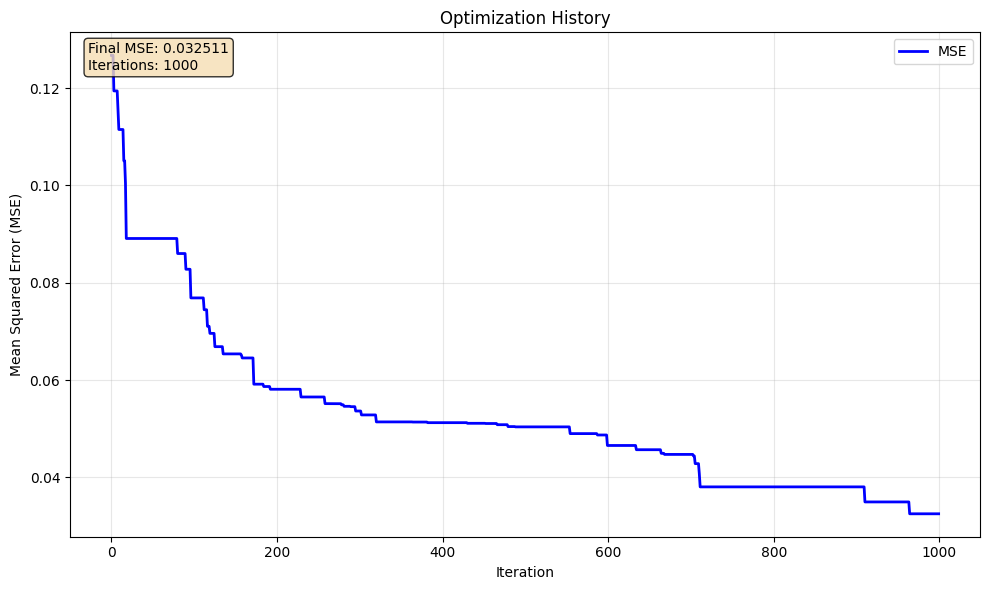

In [24]:
optimizer.plot_optimization_history(result)

Simulating optimized model on all experimental conditions...
  Experiment 1: Formula measurement (predicted=-0.2000, measured=163.4000)
  Experiment 2: Formula measurement (predicted=-0.3671, measured=131.7400)
  Experiment 3: Formula measurement (predicted=-0.3600, measured=148.7900)
  Experiment 4: Formula measurement (predicted=-0.0400, measured=186.1400)
  Experiment 5: Formula measurement (predicted=-0.4400, measured=119.4800)
  Experiment 6: Formula measurement (predicted=-0.0900, measured=167.3500)
  Experiment 7: Formula measurement (predicted=-0.2500, measured=172.6800)
  Experiment 8: Formula measurement (predicted=-0.1800, measured=145.1500)
Simulation completed: 8 data points
Plot saved to BeatAML_AUC_Venetoclax_Waves1+2_AND/prediction_vs_experimental.png
Residual plot saved to BeatAML_AUC_Venetoclax_Waves1+2_AND/residual_analysis.png
Evaluation report saved to BeatAML_AUC_Venetoclax_Waves1+2_AND/evaluation_report.txt
Results exported to BeatAML_AUC_Venetoclax_Waves1+2_AND/

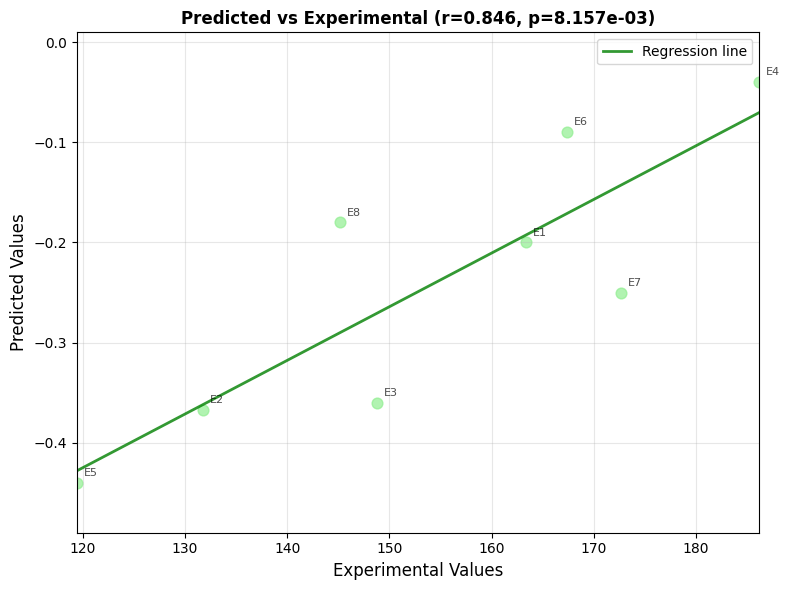

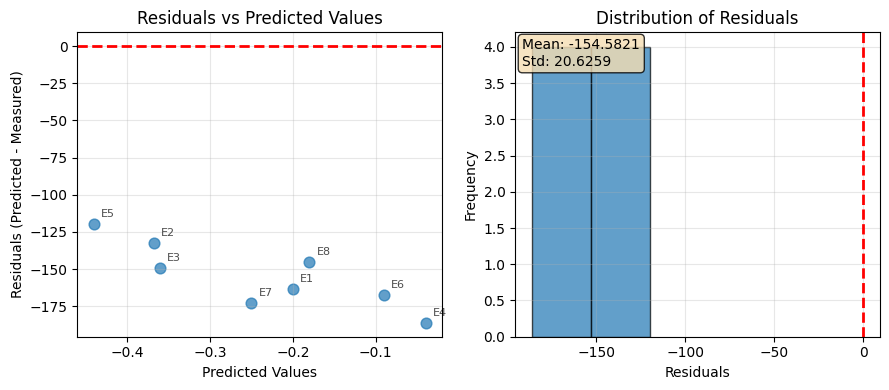

In [25]:
np.random.seed(9)
output_dir = "BeatAML_AUC_Venetoclax_Waves1+2_AND"
evaluator = BNMPy.evaluate_optimization_result(
    result, 
    optimizer, 
    output_dir=output_dir,
    plot_residuals=True,
    save=True,
    detailed=True,
    figsize=(8, 6)
)

In [29]:
# Create experimental data for Venetoclax - Waves3+4
exp_data = create_experimental_data(
    df, 
    cohort='Waves3+4',
    mutation_genes=['FLT3_ITD', 'NPM1', 'DNMT3A'],
    inhibitors=['Venetoclax'],
    output_file='../data/BeatAML_AUC_Venetoclax_Waves3+4.csv'
)

\nGenerating data for 8 profiles × 1 drugs = 8 experiments
\nSaved 8 experiments to ../data/BeatAML_AUC_Venetoclax_Waves3+4.csv
\nSummary by drug:
            Total patients   Mean AUC±SD
drug                                    
Venetoclax             174  130.05±45.02


In [30]:
BNMPy.evaluate_pbn(pbn, '../data/BeatAML_AUC_Venetoclax_Waves3+4.csv', 
    config=config, 
    Measured_formula='- AKT1 - BCL2 + CDKN2A + GSK3B - MAPK1 - MEIS1 - STAT5A + TP53',
    normalize=True,
    output_dir='BeatAML_AUC_Venetoclax_Waves3+4_AND')

Plot saved to BeatAML_AUC_Venetoclax_Waves3+4_AND/prediction_vs_experimental.png
Residual plot saved to BeatAML_AUC_Venetoclax_Waves3+4_AND/residual_analysis.png
Evaluation report saved to BeatAML_AUC_Venetoclax_Waves3+4_AND/evaluation_report.txt
Results exported to BeatAML_AUC_Venetoclax_Waves3+4_AND/detailed_results.csv
PBN saved to BeatAML_AUC_Venetoclax_Waves3+4_AND/pbn.txt


{'metrics': {'overall': {'correlation': 0.6331560073142941,
   'p_value': 0.09195418886046365,
   'mse': 0.6226561900776304,
   'rmse': 0.7890856671348367,
   'mae': 0.7476823915818253,
   'r_squared': -5.312898410537564,
   'n_points': 8},
  'per_node': {'Formula': {'correlation': 0.6331560073142941,
    'p_value': 0.09195418886046365,
    'mse': 0.6226561900776304,
    'mae': 0.7476823915818253,
    'n_points': 8}}},
 'plot_paths': {'prediction_vs_experimental': 'BeatAML_AUC_Venetoclax_Waves3+4_AND/prediction_vs_experimental.png',
  'residual_analysis': 'BeatAML_AUC_Venetoclax_Waves3+4_AND/residual_analysis.png'},
 'report_path': 'BeatAML_AUC_Venetoclax_Waves3+4_AND/evaluation_report.txt',
 'csv_path': 'BeatAML_AUC_Venetoclax_Waves3+4_AND/detailed_results.csv',
 'pbn_path': 'BeatAML_AUC_Venetoclax_Waves3+4_AND/pbn.txt',
 'simulation_results': {'experiments': [{'id': 1,
    'stimuli': [],
    'stimuli_efficacy': [],
    'inhibitors': ['BCL2'],
    'inhibitors_efficacy': [1.0],
    'me